# Purpose

This tutorial shows how to use CNA within the [Seurat](https://satijalab.org/seurat/index.html) single-cell analysis framework. All requisite downstream analysis is first done in Seurat and then CNA is run on this pre-analyzed Seurat object and the results of CNA are cached and returned in the same Seurat object. We use a real dataset from a study of stromal cells from synovial tissue ([Wei, Korsunsky et al](https://www.nature.com/articles/s41586-020-2222-z)). 

For an introduction to CNA with Seurat, see the `demo_R` vignette. 


# Install packages 

First, we need to make sure that we have Seurat and rcna packages installed. 


In [1]:
tryCatch(library(Seurat), error = function(e) {
    install.packages('Seurat')
})

tryCatch(library(rcna), error = function(e) {
    devtools::install_github('ilyakorsunsky/rcna')
})


Attaching SeuratObject



And some useful utility packages for plotting and data handling. 

In [ ]:
library(ggthemes)
library(ggplot2)
library(dplyr)
library(glue)
library(harmony)
library(patchwork)
library(purrr)
library(Matrix)
library(data.table)


In [3]:
## TO USER: Change this to your data directory 
## This directory should contain data from Broad single cell portal (see next section)
datadir <- 'data'

# Initialize Seurat object

We will use the gene expression and meta data information located in the Broad's Single Cell Portal for this [study](https://singlecell.broadinstitute.org/single_cell/study/SCP469/synovial-fibroblast-positional-identity-controlled-by-inductive-notch-signaling-underlies-pathologic-damage-in-inflammatory-arthritis). If you don't have these data, please download these files: 

- `exprs_human_barcodes.tsv.gz` Cell barcodes
- `exprs_human_genes.tsv.gz` Gene names 
- `gene_sorted-exprs_human.mtx.gz` Sparse matrix of normalized (logCP10K) counts
- `metaData.txt` Pre-annotated meta data table 


First, we initialize the expression matrix. 

In [4]:
barcodes <- fread(glue('{datadir}/exprs_human_barcodes.tsv.gz'), header = FALSE)$V1
genes <- fread(glue('{datadir}/exprs_human_genes.tsv.gz'), header = FALSE)$V1
mat <- Matrix::readMM(glue('{datadir}/gene_sorted-exprs_human.mtx.gz'))
rownames(mat) <- genes
colnames(mat) <- barcodes

Next, we'll upload the meta data table, keeping only the cells of interest to us. 

In [5]:
meta_data <- fread(glue('{datadir}/metaData.txt'))
meta_data <- meta_data[2:nrow(meta_data), ] %>% 
    data.frame() %>% 
    subset(label == 'tissue') %>%  ## only keep human primary tissue cells
    subset(cell_type != 'Leukocytes') %>% ## remove contaminating immune cells 
    dplyr::sample_frac(1L, FALSE) %>% ## shuffle rows for improved plotting downstream 
    tibble::remove_rownames() %>% 
    tibble::column_to_rownames('NAME') %>% 
    identity()


Finally, we'll create the Seurat object, making sure to align the expression matrix and meta data table. 

In [6]:
obj <- Seurat::CreateSeuratObject(
    counts = mat[, rownames(meta_data)], ## Subset expression matrix to cells in metadata
    meta.data = meta_data, 
    assay = 'RNA', 
    names.field = 2
)

Warning message:
“The following arguments are not used: row.names”
Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


In [7]:
## This is not valid, since it was computed on normalized data 
obj@meta.data$nCount_RNA <- NULL

Because of the pre-computed annotations, we have lots of info on the cells already! 

In [8]:
head(obj@meta.data)

,orig.ident,nFeature_RNA,sampleID,status,label,cell_type,cell_subtype,nUMI,nGene,percent_mito,pseudotime
,<fct>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
AAGGCAGTCGGGAGTA_OA180108B,OA180108B,2633,donor8,oa,tissue,Lining Fibroblasts,Lining Fibroblasts,9304,2633,0.0561049011177988,4.40486101400927
GGCTGGTGTGTCGCTG_RA178CD45n,RA178CD45n,1372,donor14,ra,tissue,Sublining Fibroblasts,Sublining Fibroblasts,3582,1373,0.0538805136795087,61.6841373053666
CACAAACGTTGTGGCC_OA180507,OA180507,1694,donor10,oa,tissue,Lining Fibroblasts,Lining Fibroblasts,4839,1694,0.0514569125852449,3.84956540348651
TCTGAGATCTGGTATG_RA174CD45n,RA174CD45n,1531,donor13,ra,tissue,Lining Fibroblasts,Lining Fibroblasts,4307,1531,0.0399349895518923,11.6143559345041
TACAGTGAGACAATAC_OA180430,OA180430,1460,donor9,oa,tissue,Sublining Fibroblasts,Sublining Fibroblasts,4168,1460,0.0587811900191939,22.6920710920471
ACCCACTAGTGAAGTT_BWH064CD45n,BWH064CD45n,1961,donor1,ra,tissue,Sublining Fibroblasts,Sublining Fibroblasts,5269,1962,0.0318846080850256,96.337323464527


# Requisite Seurat analyses

CNA requires us to input a cell-cell neighborhood adjacency matrix, which we do in Seurat with the `FindNeighbors` function. Before we can run that, we need to do all these other steps first: finding variable genes, scaling data, running PCA,  and harmonizing over donor ID. Running UMAP is not necessary to do CNA but it is useful to visualize the cells after CNA. 

Notes: 
- This dataset is pre-normalized, so we skip the NormalizeData step
- If you use the python umap function with reticulate, you can use the neighborhood graph to learn UMAP, so you don't compute the KNN twice. 



In [9]:
set.seed(1)
.verbose <- FALSE
obj <- obj %>% 
    ## Data already normalized, so don't do this 
#     Seurat::NormalizeData(verbose = .verbose) %>% 
    Seurat::FindVariableFeatures(verbose = .verbose) %>% 
    Seurat::ScaleData(verbose = .verbose) %>% 
    Seurat::RunPCA(verbose = .verbose) %>% 
    RunHarmony('orig.ident', verbose = .verbose) %>% 
    Seurat::FindNeighbors(verbose = .verbose, reduction = 'harmony', dims = 1:20) %>% 
    Seurat::RunUMAP(verbose = .verbose, reduction='harmony', dims=1:20) %>% 
    identity()


Warning message:
“Invalid name supplied, making object name syntactically valid. New object name is Seurat..ProjectDim.RNA.harmony; see ?make.names for more details on syntax validity”
Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”


As a sanity check, let's make sure that the donors are mixed and the cell types are separated in the UMAP embedding. In the last panel, we can see that the region with sublining fibroblasts has more cells from RA donors, whereas the lining fibroblasts come more from OA donors. 

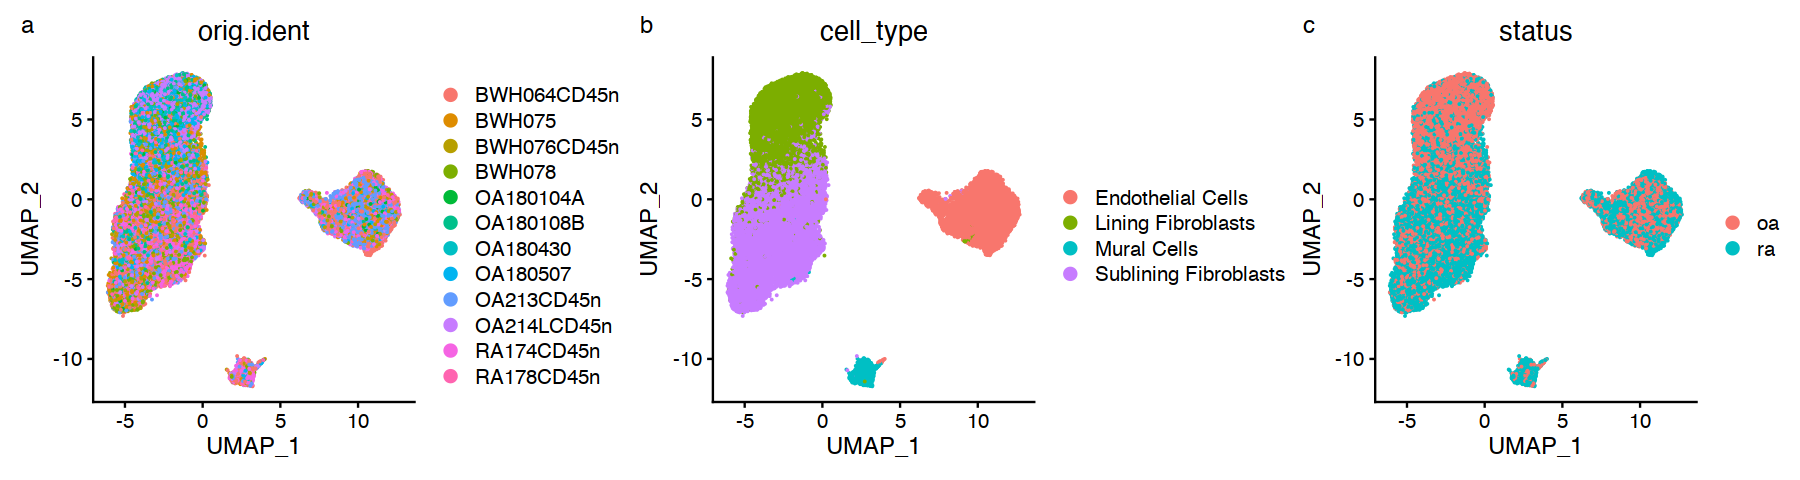

In [24]:
options(repr.plot.width=15, repr.plot.height=4)
Seurat::DimPlot(obj, group.by = 'orig.ident')[[1]] + 
Seurat::DimPlot(obj, group.by = 'cell_type')[[1]] + 
Seurat::DimPlot(obj, group.by = 'status')[[1]] + 
plot_annotation(tag_levels = 'a') 


Since the above computations may take some time, we'll save the intermediate results. 

In [11]:
system.time({
    saveRDS(obj, glue('{datadir}/cache_seurat_notch.rds'))
})
plot_annotation

   user  system elapsed 
 63.600   1.179  67.886 

# CNA



## Load data

If we need to, let's load the cached Seurat object from the code above. 

In [12]:
obj <- readRDS(glue('{datadir}/cache_seurat_notch.rds'))

In [13]:
## First, let's convert disease status into a numerical variable
## By first casting as a factor, we can control which values are base (here, "oa")
## so that positive associations will denote association with status="ra"
obj@meta.data$status_val <- as.numeric(factor(obj@meta.data$status, c('oa', 'ra')))


## Do association

The rcna package provides a seamless interface to CNA for Seurat objects through the `association.Seurat` function. All the translation to and from Seurat data structures is automatically performed under the hood. 


In [14]:
obj <- association.Seurat(
    seurat_object = obj, 
    test_var = 'status_val', 
    samplem_key = 'orig.ident', 
    graph_use = 'RNA_nn', 
    verbose = TRUE,
    batches = NULL, ## no batch variables to include
    covs = NULL ## no covariates to include 
)

Build NAM PCs

stopping after 4 steps

only one unique batch supplied to qc

only one unique batch supplied to prep

Perform association testing

computing neighborhood-level FDRs



The main association results are saved into the Seurat object's meta data table: 

- cna_ncorrs: correlation with tested variable (here, disease status)
- cna_ncorrs_fdr10: same as above but with a statistical significance cutoff at FDR < 10%. 
- cna_ncorrs_fdr5: same as above but with a statistical significance cutoff at FDR < 5%. 


In [15]:
head(obj@meta.data)

,orig.ident,nFeature_RNA,sampleID,status,label,cell_type,cell_subtype,nUMI,nGene,percent_mito,pseudotime,status_val,cna_ncorrs,cna_ncorrs_fdr05,cna_ncorrs_fdr10
,<fct>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
AAGGCAGTCGGGAGTA_OA180108B,OA180108B,2633,donor8,oa,tissue,Lining Fibroblasts,Lining Fibroblasts,9304,2633,0.0561049011177988,4.40486101400927,1,-0.7039922,-0.7039922,-0.7039922
GGCTGGTGTGTCGCTG_RA178CD45n,RA178CD45n,1372,donor14,ra,tissue,Sublining Fibroblasts,Sublining Fibroblasts,3582,1373,0.0538805136795087,61.6841373053666,2,0.6627156,0.6627156,0.6627156
CACAAACGTTGTGGCC_OA180507,OA180507,1694,donor10,oa,tissue,Lining Fibroblasts,Lining Fibroblasts,4839,1694,0.0514569125852449,3.84956540348651,1,-0.4990410,0.0000000,-0.4990410
TCTGAGATCTGGTATG_RA174CD45n,RA174CD45n,1531,donor13,ra,tissue,Lining Fibroblasts,Lining Fibroblasts,4307,1531,0.0399349895518923,11.6143559345041,2,0.5738451,0.5738451,0.5738451
TACAGTGAGACAATAC_OA180430,OA180430,1460,donor9,oa,tissue,Sublining Fibroblasts,Sublining Fibroblasts,4168,1460,0.0587811900191939,22.6920710920471,1,-0.5986700,-0.5986700,-0.5986700
ACCCACTAGTGAAGTT_BWH064CD45n,BWH064CD45n,1961,donor1,ra,tissue,Sublining Fibroblasts,Sublining Fibroblasts,5269,1962,0.0318846080850256,96.337323464527,2,0.6334816,0.6334816,0.6334816


## Visualize association results 

We can visualize these results in UMAP space to see which neighborhoods are most associated with disease status. 

- Panels a and b show per-neighborhood correlation with disease status.
    - Neighborhoods colored blue have more ra donors. 
    - Neighborhoods colored orange have more oa donors. 
    - The global p value in panel a denotes the overall association of all neighborhood with disease status. 
- Panel b shows filtered results, so all correlations that fall below signficance (FDR>10%) are colored grey. 
- Panel c colors cells by disease status. This is the raw data that is summarized by the CNA correlation statistics in panels a and b. 



Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



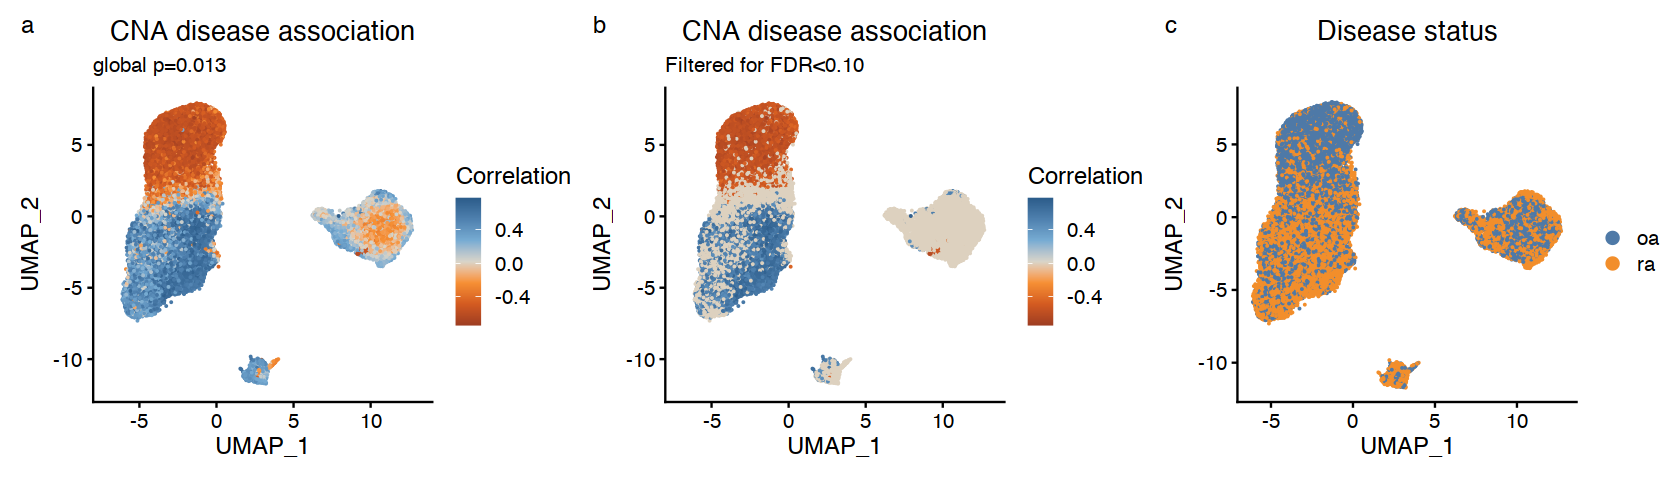

In [23]:
options(repr.plot.width=14, repr.plot.height=4)
FeaturePlot(obj, features = c('cna_ncorrs'))[[1]] + 
    scale_color_gradient2_tableau() + 
    labs(
        title = 'CNA disease association', color = 'Correlation',
        subtitle = sprintf('global p=%0.3f', obj@reductions$cna@misc$p)
    ) + 
FeaturePlot(obj, features = c('cna_ncorrs_fdr10'))[[1]] + 
    scale_color_gradient2_tableau() + 
    labs(title = 'CNA disease association', subtitle = 'Filtered for FDR<0.10', color = 'Correlation') + 
DimPlot(obj, group.by = 'status')[[1]] + 
    scale_color_tableau() + labs(title = 'Disease status') + 
plot_layout(nrow = 1) + 
plot_annotation(tag_levels = 'a')

## Intermediate results 

The raw and filtered correlation values attached to the meta data represent the primary outputs of CNA. However, advanced users may also be interested in some intermediate results, as described in the `demo_R` notebook. These results can be found in the `misc` slot of the cna reduction of the Seurat object. 


In [17]:
names(obj@reductions$cna@misc)

[1] "p"              "nullminps"      "k"              "ncorrs"        
 [5] "fdrs"           "fdr_5p_t"       "fdr_10p_t"      "yhat"          
 [9] "ycond"          "ks"             "beta"           "r2"            
[13] "r2_perpc"       "nullr2_mean"    "nullr2_std"     "NAM_embeddings"
[17] "NAM_loadings"   "NAM_svs"

## Next steps 

- This simple example does not include batch or covariate variables. Try a dataset with this type of information to see how including these confounders changes association results. 
- One of the best things about CNA is that it captures *covarying* neighborhoods, which don't need to be adjacent in UMAP space. Try to look into the NAM PC embeddings to find which cell neighborhoods (see obj@reductions$cna@cell.embeddings) covary with one another. 

- A known limitation of PCA is that it explains variance in the cells that are more abundant. There may be signal in the endothelial cells and mural cells that is missed when analyzing them together with fibroblasts. Try to subset these populations and repeat CNA in this finer resolution. 
